<a href="https://colab.research.google.com/github/yiftachsa/AI-Advanced/blob/main/IoU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

def build_iou_matrix(bboxes_a: tf.Tensor, bboxes_b: tf.Tensor):
    """
    Computes an [N x M] matrix of IoUs between two sets of boxes.
    Each box is [x1, y1, x2, y2]

    @param bboxes_a: Tensor of shape [N, 4]
    @param bboxes_b: Tensor of shape [M, 4]
    @return: IoU matrix of shape [N, M]
    """
    #expand dims for broadcasting
    bboxes_a_expend = tf.expand_dims(bboxes_a, axis=1) # (N, 1, 4)
    bboxes_b_expend = tf.expand_dims(bboxes_b, axis=0) # (1, M, 4)

    #intersection
    top_left_x = tf.maximum(bboxes_a_expend[..., 0], bboxes_b_expend[..., 0]) # max(x_a1,x_b1) (N,M)
    top_left_y = tf.minimum(bboxes_a_expend[..., 1], bboxes_b_expend[..., 1]) # min(y_a1,y_b1) (N,M)
    bottom_right_x = tf.minimum(bboxes_a_expend[..., 2], bboxes_b_expend[..., 2]) # min(x_a2,x_b2) (N,M)
    bottom_right_y = tf.maximum(bboxes_a_expend[..., 3], bboxes_b_expend[..., 3]) # max(y_a2,y_b2) (N,M)

    w = tf.maximum(0, bottom_right_x - top_left_x)
    h = tf.maximum(0, top_left_y - bottom_right_y)
    area_intersect = tf.multiply(w,h) # (N,M)

    # Union
    area_a = tf.multiply(tf.subtract(bboxes_a[:,2], bboxes_a[:,0]), tf.subtract(bboxes_a[:,1], bboxes_a[:,3])) #(N,)
    area_b = tf.multiply(tf.subtract(bboxes_b[:,2], bboxes_b[:,0]), tf.subtract(bboxes_b[:,1], bboxes_b[:,3])) #(M,)

    #expand dims for broadcasting
    area_a_expend = tf.expand_dims(area_a, axis=1) # (N, 1)
    area_b_expend = tf.expand_dims(area_b, axis=0) # (1, M)
    area_union = tf.add(area_a_expend, area_b_expend) # (N,M) P(A U B) = P(A) + P(B) - P (A, B)
    area_union = tf.subtract(area_union, area_intersect)

    iou = tf.divide(area_intersect, area_union)# (N,M)
    return iou

In [3]:
import numpy as np

def get_bboxes(N=10):
  p1 = np.random.rand(N,2)*5
  p2_x = p1[:,0]+np.random.rand(N)
  p2_y = p1[:,1]-np.random.rand(N)
  p2 = np.stack([p2_x, p2_y], axis=1)

  bboxes = np.stack([p1, p2], axis=1)
  bboxes = np.reshape(bboxes, (N, 4))
  return bboxes

def get_close_bboxes(bboxes):
  N = bboxes.shape[0]
  p1_x = bboxes[:,0]+np.where(np.random.random(N)>0.5, np.random.random(N), -np.random.random(N))
  p1_y = bboxes[:,1]+np.where(np.random.random(N)>0.5, np.random.random(N), -np.random.random(N))

  p2_x = p1_x+np.random.rand(N)
  p2_y = p1_y-np.random.rand(N)
  bboxes = np.stack([p1_x, p1_y, p2_x, p2_y], axis=1)

  # bboxes = np.stack([p1, p2], axis=1)
  # bboxes = np.reshape(bboxes, (N, 4))
  return bboxes

bboxes_a = get_bboxes(5)
bboxes_b_1 = get_close_bboxes(bboxes_a)
bboxes_b_2 = get_bboxes(3)
bboxes_b = np.vstack((bboxes_b_1, bboxes_b_2))

In [6]:
iou_mat = build_iou_matrix(bboxes_a, bboxes_b)

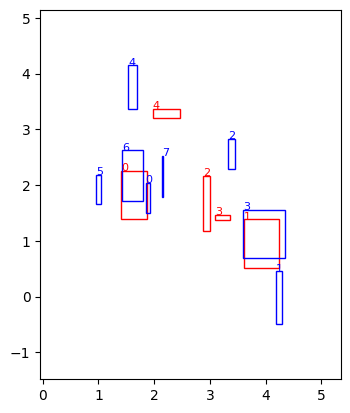

In [7]:
# prompt: plot bboxes_a and bboxes_b with tags of index per bbox both on the same graph

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bboxes_with_tags(bboxes_a, bboxes_b):
  """
  Plots two sets of bounding boxes on the same graph with index tags.

  Args:
    bboxes_a: Numpy array of shape [N, 4] representing the first set of boxes.
    bboxes_b: Numpy array of shape [M, 4] representing the second set of boxes.
  """
  fig, ax = plt.subplots(1)
  ax.set_aspect('equal', adjustable='box')

  for i, bbox in enumerate(bboxes_a):
    rect = patches.Rectangle((bbox[0], bbox[3]), bbox[2] - bbox[0], bbox[1] - bbox[3],
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1], str(i), color='r', fontsize=8)

  for i, bbox in enumerate(bboxes_b):
    rect = patches.Rectangle((bbox[0], bbox[3]), bbox[2] - bbox[0], bbox[1] - bbox[3],
                             linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1], str(i), color='b', fontsize=8)

  # Set limits to encompass all bounding boxes
  all_bboxes = np.concatenate((bboxes_a, bboxes_b), axis=0)
  min_x = np.min(all_bboxes[:, 0])
  max_x = np.max(all_bboxes[:, 2])
  min_y = np.min(all_bboxes[:, 3])
  max_y = np.max(all_bboxes[:, 1])

  ax.set_xlim(min_x - 1, max_x + 1)
  ax.set_ylim(min_y - 1, max_y + 1)

  plt.show()

plot_bboxes_with_tags(bboxes_a, bboxes_b)


In [13]:
iou_mat[1,3]

<tf.Tensor: shape=(), dtype=float64, numpy=0.5721841847758055>